# Tuning hyper-parameters

Now that we've seen how powerful this feature weighted regression model can be, we have some house-keeping to do.
While the model is as simple as it can be, there are still __some__ parameters that we can tune. In the case of a Ridge Regression, you have the penalty term &lambda;, and in the case of the feature weighted model you have the width, S, of the weighting term, which effectively acts as a kernel in our case.

In addition to this, both the period of the periodic signal and the number of harmonics in our Fourier basis can technically be optimised as hyper-parameters. While the number of harmonics is less important because of the feature weighting which naturally suppresses high frequency harmonics, the period is something that can benefit from being tuned as a hyperparameter. Furthermore, this cleverly allows us to avoid including this in the regression as a feature since the embedding depends on the period in a non-linear fashion!

There are several well-known methods for determining the optimal values of hyper-parameters in a model. In the case of U Gru, we're dealing with highly correlated data, and we're not exactly looking to predict or forecast the data into the future, so we can use tuning methods that don't explicitly test the time-series nature of the data. However, we can imagine scenarios in which we might want to, so we'll compare the outcomes for hyper-parameters tuned on our data ignoring and accounting for the time-series behaviour of our data. Additionally, there will be times where we work with non-uniformly sampled time-series data, so we'll also try using a K-Folds cross-validation routine inside our tuning loop. 


In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

from pythia.timeseries.lombscargle import LS_periodogram
from puffins.utils import construct_design_matrix
from puffins.solver import solve
from puffins.weight_functions import matern32
from puffins.basis_functions import basis_constant, basis_linear, basis_polynomial

from puffins.data import TimeSeries,LinearModel
from puffins.tuner import Tuner


np.random.seed(8675309) # MAGIC to enforce reproducibility
RCOND = 1e-14 # MAGIC input to `np.linalg.lstsq()`
plotnum=1

Let's download / unpack the data

In [2]:
time, flux = np.loadtxt('../data/ugru.dat').T
period = 1.88045
n_harmonics = 100
feature_weighting_width = 0.5

In [13]:
data = TimeSeries(time, flux)
fwls = LinearModel('fw', basis_functions=[basis_constant,], feature_embedding='fourier', 
                   feature_weighting_function=matern32, feature_weighting_width=feature_weighting_width,
                   period=period, n_harmonics=100, W=None)

fwls.set_X_train(data.predictors)
fwls.train(data.targets)
untuned_model = fwls.trained_model
untuned_mse = fwls.trained_mse


In [14]:
period_ = {'period': [1.87,1.89,'uniform']}
width_ = {'feature_weighting_width': [0.001,1.,'uniform']}

In [15]:
period_tuner = Tuner( fwls, hyperpars=period_, n_trials=200, direction='minimize')
period_tuner.run_tune(time, flux)
print(period_tuner.best_hyperpars)
fwls.set_X_kwargs(update=True, period=period_tuner.best_hyperpars['period'])

[I 2025-02-04 11:23:26,301] A new study created in memory with name: no-name-7f6670d8-f557-45ff-855c-ce0ed25c64be
[I 2025-02-04 11:23:26,350] Trial 0 finished with value: 0.0027104056103282293 and parameters: {'period': 1.8832093449534006}. Best is trial 0 with value: 0.0027104056103282293.
[I 2025-02-04 11:23:26,416] Trial 1 finished with value: 0.0045043642674841575 and parameters: {'period': 1.8738941571734404}. Best is trial 0 with value: 0.0027104056103282293.
[I 2025-02-04 11:23:26,474] Trial 2 finished with value: 0.0040880290448024196 and parameters: {'period': 1.8745935581589712}. Best is trial 0 with value: 0.0027104056103282293.
[I 2025-02-04 11:23:26,545] Trial 3 finished with value: 0.006453231615803228 and parameters: {'period': 1.88986406949237}. Best is trial 0 with value: 0.0027104056103282293.
[I 2025-02-04 11:23:26,621] Trial 4 finished with value: 0.006971362196137304 and parameters: {'period': 1.8704682848215346}. Best is trial 0 with value: 0.0027104056103282293.


{'period': 1.8804917046485607}


In [16]:
width_tuner = Tuner( fwls, hyperpars=width_, n_trials=50, direction='minimize')
width_tuner.run_tune(time, flux)


[I 2025-02-04 11:23:40,179] A new study created in memory with name: no-name-8bd185a3-20e2-4b19-ada5-8afba18f47b3
[I 2025-02-04 11:23:40,259] Trial 0 finished with value: 6.6537346233674576e-06 and parameters: {'feature_weighting_width': 0.035043906461710905}. Best is trial 0 with value: 6.6537346233674576e-06.
[I 2025-02-04 11:23:40,324] Trial 1 finished with value: 0.0023377200608202084 and parameters: {'feature_weighting_width': 0.5013050258026888}. Best is trial 0 with value: 6.6537346233674576e-06.
[I 2025-02-04 11:23:40,405] Trial 2 finished with value: 0.004871101428037887 and parameters: {'feature_weighting_width': 0.6543331960228617}. Best is trial 0 with value: 6.6537346233674576e-06.
[I 2025-02-04 11:23:40,481] Trial 3 finished with value: 1.0125615710140213e-05 and parameters: {'feature_weighting_width': 0.11957279814503102}. Best is trial 0 with value: 6.6537346233674576e-06.
[I 2025-02-04 11:23:40,548] Trial 4 finished with value: 9.836144170100637e-06 and parameters: {'f

In [19]:
fwls.set_X_kwargs(update=True, feature_weighting_width=width_tuner.best_hyperpars['feature_weighting_width'])

In [20]:
fwls.set_X_train(data.predictors)
fwls.train(data.targets)

Great, now that we've tuned the period and feature width, we can see what the model looks like.

Text(0, 0.5, '(Predicted) Flux')

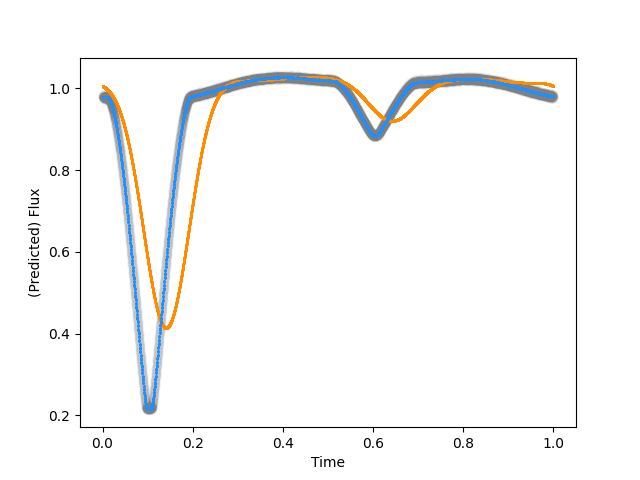

In [31]:
plotnum += 1
fig_, ax_ = plt.subplots(num=plotnum)
ph_untuned = data.predictors / period % 1
ph_tuned = data.predictors / fwls.X_kwargs['period'] % 1
ax_.plot(ph_tuned, data.targets, 'o', color='grey', alpha=0.01)
ax_.plot(ph_untuned, untuned_model, '+', ms=1, color='darkorange', alpha=0.85)
ax_.plot(ph_tuned, fwls.trained_model, 'x', ms=1, color='dodgerblue')
# ax_.plot(xnew, fwls.predict(xnew)[1], '--', color='darkorange')
ax_.set_xlabel('Time')
ax_.set_ylabel('(Predicted) Flux')

In [ ]:
joint_tuner = {'feature_weighting_width': [0.001,1,'uniform'], 'period': [1.87,1.89,'uniform']}